In [14]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from keras.layers import Input, LSTM, Dense, concatenate, Embedding, Dropout
from keras.models import Model
import time
import winsound

In [15]:
from word2vec import load_vectors, convert_to_word_vectors
word_to_vec_map = load_vectors('crawl-300d-2M.vec')

In [16]:
# train_data_comments = pd.read_csv("Network/balanced_trainset.csv", na_filter=False)
# train_data_features = pd.read_csv("Network/preprocessed_balanced_trainset.csv")
# train_examples = train_data_features.loc[:, train_data_features.columns != "label"]
# train_labels = train_data_features.label
# test_data_comments = pd.read_csv("Network/balanced_testset.csv", na_filter=False)
# test_data_features = pd.read_csv("Network/preprocessed_balanced_testset.csv")
# test_examples = test_data_features.loc[:, test_data_features.columns != "label"]
# test_labels = test_data_features.label

train_data_comments = pd.read_csv("TRAIN-balanced_trainset.csv", na_filter=False, memory_map=True)
train_data_features = pd.read_csv("TRAIN-preprocessed_balanced_trainset.csv", memory_map=True)
train_examples = train_data_features.loc[:, train_data_features.columns != "label"]
train_labels = train_data_features.label
test_data_comments = pd.read_csv("TEST-balanced_testset.csv", na_filter=False, memory_map=True)
test_data_features = pd.read_csv("TEST-preprocessed_balanced_testset.csv", memory_map=True)
test_examples = test_data_features.loc[:, test_data_features.columns != "label"]
test_labels = test_data_features.label


In [17]:
def build():
    main_input = Input(shape=(None, 300), dtype='float32')
    lstm_out = LSTM(32)(main_input)
    # auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

    auxiliary_input = Input(shape=(10,), name='aux_input')

    x = concatenate([lstm_out, auxiliary_input])
    x = Dense(64, activation='sigmoid')(x)
    x = Dropout(0.2)(x)
    
    main_output = Dense(2, activation='sigmoid', name='main_output')(x)

    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])

    return model

In [18]:
def preprocess_comment(comment):
    preprocessed_comment = convert_to_word_vectors(comment, word_to_vec_map)
    return preprocessed_comment

In [19]:
def data_generator(batch_size, test_set=False):
    if(batch_size > 1):
        print("batch size cannot be bigger than 1.")
        exit()
    batch_preprocessed_data = np.zeros((batch_size, 10))
    batch_labels = np.zeros((batch_size, 2))
    batch_comments = None
    data_comments = test_data_comments if test_set else train_data_comments
    data_examples = test_examples if test_set else train_examples
    data_labels = test_labels if test_set else train_labels
    examples = len(data_examples)
    test_index = 0
    while True:
        if test_set:
            index = test_index
            test_index = ((test_index + 1) % examples)
        else:
            index = np.random.choice(examples)
        if data_comments.text[index] == "":
            print(f"{index}: {data_comments.text[index]}")
        else:
            comment = preprocess_comment(data_comments.text[index])
            features = data_examples.loc[index]
            label = data_labels[index]
            batch_comments = np.zeros((batch_size, comment.shape[0], 300))
            batch_comments[0] = comment
            batch_preprocessed_data[0] = features
            batch_labels[0] = to_categorical(label,2)
        yield [batch_comments, batch_preprocessed_data], batch_labels

In [20]:
def fit(model, optimizer, epochs, batch_size, metrics):
    steps_per_epoch = np.ceil(len(train_labels) / batch_size)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    H = model.fit_generator(
        data_generator(batch_size),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        verbose=1
    )
    metrics['loss'] += H.history["loss"]
    metrics['acc'] += H.history["acc"]

In [21]:
def evaluate(model):
    batch_size = 1
    # evaluate the network
    print("[INFO] evaluating network...")
    evaluation = model.evaluate_generator(data_generator(batch_size, True), steps=len(test_examples) / batch_size)
    print("Val_loss: {}, Val_acc: {}".format(evaluation[0], evaluation[1]))


In [22]:
def plot(metrics, title=""):
    N = np.arange(0, len(metrics['loss']))
    plt.style.use("ggplot")

    for key in metrics.keys():
        plt.plot(N, metrics[key], label=key)

    plt.title(title)
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig("plot.png")
    plt.show()


In [23]:
def test(model, numbers):
    for i in numbers:
        print("Label should be {}".format(test_labels[i]))
        comment = preprocess_comment(test_data_comments.text[i])
        aux_input = np.array(test_examples.loc[i]).reshape(1,10)
        print(model.predict([comment.reshape(1,comment.shape[0],300), aux_input]))


In [24]:
def train(model, optimizer, epochs, batch_size=1):
    metrics = {'loss': [], 'acc': []}
    fit(model, optimizer, epochs, batch_size, metrics)
    evaluate(model)
    test(model, [0, 199])
    plot(metrics, "Training Loss and Accuracy")


Epoch 1/30
1010826/1010826 [==============================] - 10204s 10ms/step - loss: 0.6909 - acc: 0.5221
Epoch 2/30
 654947/1010826 [==================>...........] - ETA: 1:00:01 - loss: 0.6896 - acc: 0.5282914178: 


1010826/1010826 [==============================] - 10216s 10ms/step - loss: 0.6894 - acc: 0.5287
Epoch 3/30
1010826/1010826 [==============================] - 10191s 10ms/step - loss: 0.6895 - acc: 0.5285
Epoch 4/30
 178238/1010826 [====>.........................] - ETA: 2:19:51 - loss: 0.6890 - acc: 0.5322445204: 


1010826/1010826 [==============================] - 10192s 10ms/step - loss: 0.6894 - acc: 0.5291 -  
Epoch 5/30
 386414/1010826 [==========>...................] - ETA: 1:44:57 - loss: 0.6894 - acc: 0.5300199910: 


1010826/1010826 [==============================] - 10181s 10ms/step - loss: 0.6894 - acc: 0.5299
Epoch 6/30
 845043/1010826 [========================>.....] - ETA: 27:45 - loss: 0.6894 - acc: 0.5300524263: 


1010826/1010826 [==============================] - 10163s 10ms/step - loss: 0.6894 - acc: 0.5297
Epoch 7/30
1010826/1010826 [==============================] - 10151s 10ms/step - loss: 0.6895 - acc: 0.5297
Epoch 8/30
 395513/1010826 [==========>...................] - ETA: 1:43:17 - loss: 0.6894 - acc: 0.52991009303: 


1010826/1010826 [==============================] - 10161s 10ms/step - loss: 0.6893 - acc: 0.5304
Epoch 9/30
 907395/1010826 [=========================>....] - ETA: 17:17 - loss: 0.6893 - acc: 0.5298569280: 


1010826/1010826 [==============================] - 10139s 10ms/step - loss: 0.6893 - acc: 0.5298
Epoch 10/30
1010826/1010826 [==============================] - 10137s 10ms/step - loss: 0.6896 - acc: 0.5296
Epoch 11/30
 263620/1010826 [======>.......................] - ETA: 2:05:24 - loss: 0.6895 - acc: 0.528956269: 


1010826/1010826 [==============================] - 10161s 10ms/step - loss: 0.6896 - acc: 0.5294
Epoch 12/30
 867379/1010826 [========================>.....] - ETA: 24:05 - loss: 0.6893 - acc: 0.5302898863: 


1010826/1010826 [==============================] - 10172s 10ms/step - loss: 0.6893 - acc: 0.5301
Epoch 13/30
1010826/1010826 [==============================] - 10177s 10ms/step - loss: 0.6894 - acc: 0.5298
Epoch 14/30
 253089/1010826 [======>.......................] - ETA: 2:07:20 - loss: 0.6896 - acc: 0.5316135348: 


1010826/1010826 [==============================] - 10193s 10ms/step - loss: 0.6894 - acc: 0.5310
Epoch 15/30
 931886/1010826 [==========================>...] - ETA: 13:14 - loss: 0.6895 - acc: 0.5312936221: 


1010826/1010826 [==============================] - 10167s 10ms/step - loss: 0.6895 - acc: 0.5311
Epoch 16/30
1010826/1010826 [==============================] - 10188s 10ms/step - loss: 0.6893 - acc: 0.5301
Epoch 17/30
 394405/1010826 [==========>...................] - ETA: 1:43:41 - loss: 0.6897 - acc: 0.5294683899: 


1010826/1010826 [==============================] - 10184s 10ms/step - loss: 0.6894 - acc: 0.5301
Epoch 18/30
 647228/1010826 [==================>...........] - ETA: 1:00:56 - loss: 0.6894 - acc: 0.5308199910: 


1010826/1010826 [==============================] - 10154s 10ms/step - loss: 0.6893 - acc: 0.5309
Epoch 19/30
1010826/1010826 [==============================] - 10179s 10ms/step - loss: 0.6894 - acc: 0.5315
Epoch 20/30
 130785/1010826 [==>...........................] - ETA: 2:28:12 - loss: 0.6898 - acc: 0.5306683899: 


1010826/1010826 [==============================] - 10181s 10ms/step - loss: 0.6894 - acc: 0.5324
Epoch 21/30
 379752/1010826 [==========>...................] - ETA: 1:45:49 - loss: 0.6892 - acc: 0.5307859333: 


1010826/1010826 [==============================] - 10174s 10ms/step - loss: 0.6892 - acc: 0.5315
Epoch 22/30
 650544/1010826 [==================>...........] - ETA: 1:00:30 - loss: 0.6896 - acc: 0.5304 ETA: 1:00:30 - loss: 0.936221: 


1010826/1010826 [==============================] - 10166s 10ms/step - loss: 0.6895 - acc: 0.5309
Epoch 23/30
1010826/1010826 [==============================] - 10159s 10ms/step - loss: 0.6898 - acc: 0.5304
Epoch 24/30
 241516/1010826 [======>.......................] - ETA: 2:09:48 - loss: 0.6897 - acc: 0.53061009303: 


1010826/1010826 [==============================] - 10209s 10ms/step - loss: 0.6894 - acc: 0.5308
Epoch 25/30
 567634/1010826 [===============>..............] - ETA: 1:14:51 - loss: 0.6896 - acc: 0.5292878050: 


1010826/1010826 [==============================] - 10203s 10ms/step - loss: 0.6896 - acc: 0.5297
Epoch 26/30
1010826/1010826 [==============================] - 10198s 10ms/step - loss: 0.6896 - acc: 0.5293
Epoch 27/30


1010826/1010826 [==============================] - 10186s 10ms/step - loss: 0.6896 - acc: 0.5289
Epoch 28/30
 544856/1010826 [===============>..............] - ETA: 1:18:26 - loss: 0.6896 - acc: 0.5281524263: 


1010826/1010826 [==============================] - 10201s 10ms/step - loss: 0.6895 - acc: 0.5284
Epoch 29/30
1010826/1010826 [==============================] - 10216s 10ms/step - loss: 0.6896 - acc: 0.5292
Epoch 30/30
 211049/1010826 [=====>........................] - ETA: 2:14:41 - loss: 0.6900 - acc: 0.5276978220: 


1010826/1010826 [==============================] - 10192s 10ms/step - loss: 0.6897 - acc: 0.5274
[INFO] evaluating network...
Val_loss: 0.6928448941248528, Val_acc: 0.5125722945597377
Label should be 1
[[0.99988997 0.99999547]]
Label should be 1
[[0.9974957 1.       ]]


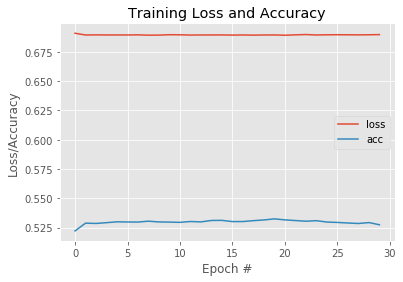

305490.0450658798


In [25]:
    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 500
    start = time.time()
    model = build()
    epochs = 30
    optimizer = 'Adam'
    train(model, optimizer, epochs)
    end = time.time()
    print(end - start)
    winsound.Beep(frequency, duration)
    winsound.Beep(frequency, duration)